# Chapter 8: Conditional GAN

In [1]:
%matplotlib inline

from keras import backend as K

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

## Generator

In [3]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(
                128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(
                64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(
                1, kernel_size=3, strides=2, padding='same'))

    # Output layer with Tanh activation
    model.add(Activation('tanh'))
    
    # Random noise vector z
    z = Input(shape=(z_dim,))
    
    # Conditioning label:
    # Integer 0-9 denoting the number G should generate
    label = Input(shape=(1,), dtype='int32')
    
    # Embedding layer:
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape: (batch_size, 1, z_dim)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    
    # Flatten the embedding 3D tensor into 2D tensor with shape: (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)
    
    # Element-wise product of the vectors z and the label embeddings
    joined_representation = multiply([z, label_embedding])
    
    img = model(joined_representation)

    return Model([z, label], img)

## Discriminator

In [4]:
def build_discriminator(img_shape):

    model = Sequential()
    
    # Convolutional layer, from 28x28x2 into 14x14x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, 
                             input_shape=(img_rows, img_cols, 2), padding='same'))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x64 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Flatten the tensor and apply sigmoid activation function
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
       
    # Conditioning label:
    # Integer 0-9 denoting the number G should generate
    label = Input(shape=(1,), dtype='int32')
    
    # Embedding layer:
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape: (batch_size, 1, 28*28*1)
    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    
    # Flatten the embedding 3D tensor into 2D tensor with shape: (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)
    
    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)
    
    # Concatenate images with corresponding label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])
     
    prediction = model(concatenated)
    
    return Model([img, label], prediction)

## Build the Model

In [5]:
# -------------------------
#  Build the Discriminator
# -------------------------

# Build and compile the Discriminator 
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(), metrics=['accuracy'])

# ---------------------
#  Build the Generator
# ---------------------

generator = build_generator(img_shape, z_dim)

# The Generator takes noise and the target label as input
# and generates the corresponding digit for that label
z = Input(shape=(z_dim,))
label = Input(shape=(1,))
img = generator([z, label])

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

prediction = discriminator([img, label])

# Combined GAN model with fixed Discriminator to train the Generator
combined = Model([z, label], prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [6]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    
    # Load the dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real images and their labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])

        # Train the Discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        
        # Generate a batch of noise vectors
        z = np.random.normal(0, 1, (batch_size, z_dim))
        
        # Get a batch of random labels
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        # Train the Generator
        g_loss = combined.train_on_batch([z, labels], real)

        
        if iteration % sample_interval == 0:

            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100 * d_loss[1], g_loss))

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            sample_images()

In [7]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, z_dim))
    
    labels = np.arange(0, 10).reshape(-1, 1)
    
    # Generate images from random noise
    gen_imgs = generator.predict([z, labels])

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5
 
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(10,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

In [8]:
# Suppress warnings because the warning Keras gives us about non-trainable parameters is by design:# Suppr 
# The Generator trainable parameters are intentionally held constant during Discriminator training and vice versa
import warnings; warnings.simplefilter('ignore')

0 [D loss: 1.176541, acc.: 39.06%] [G loss: 0.281973]
1000 [D loss: 0.000228, acc.: 100.00%] [G loss: 10.901989]
2000 [D loss: 0.024377, acc.: 100.00%] [G loss: 1.649951]
3000 [D loss: 0.066912, acc.: 98.44%] [G loss: 4.959989]
4000 [D loss: 0.111330, acc.: 98.44%] [G loss: 3.068515]
5000 [D loss: 0.066398, acc.: 98.44%] [G loss: 1.896251]
6000 [D loss: 0.270324, acc.: 87.50%] [G loss: 2.414239]
7000 [D loss: 0.826525, acc.: 67.19%] [G loss: 5.282726]
8000 [D loss: 0.469176, acc.: 78.12%] [G loss: 4.842884]
9000 [D loss: 0.082781, acc.: 96.88%] [G loss: 4.231546]
10000 [D loss: 0.062655, acc.: 98.44%] [G loss: 4.645263]
11000 [D loss: 0.599296, acc.: 68.75%] [G loss: 2.470945]


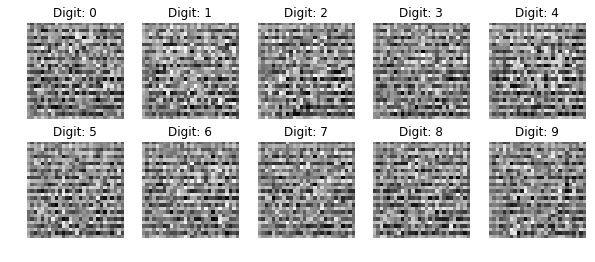

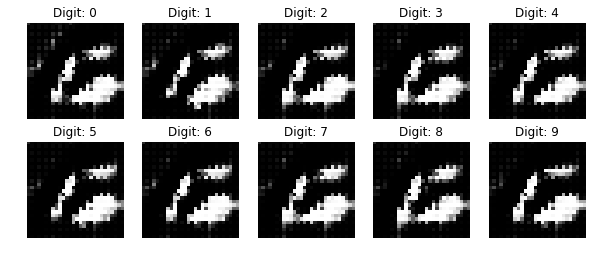

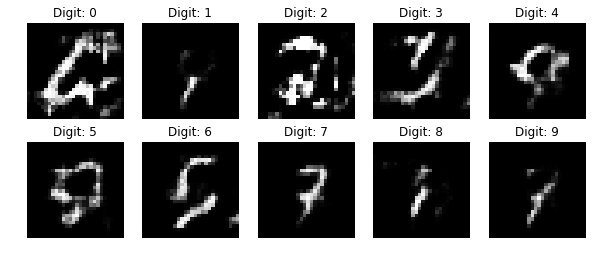

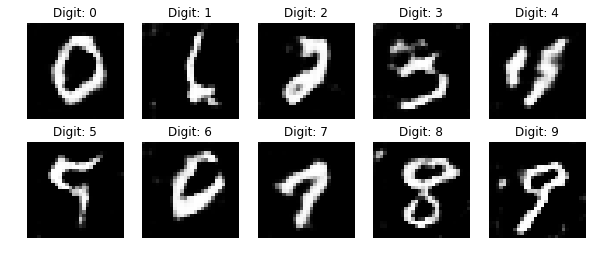

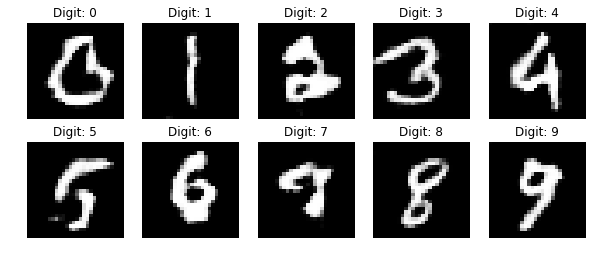

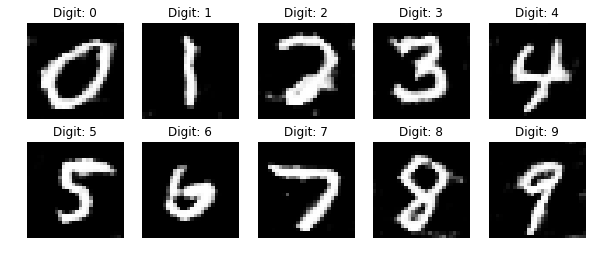

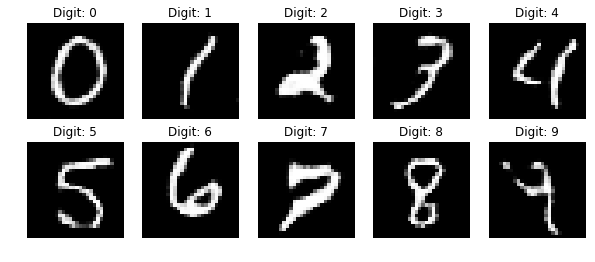

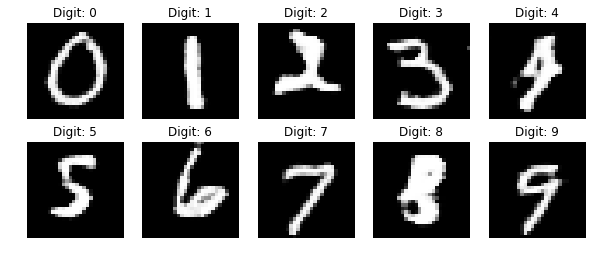

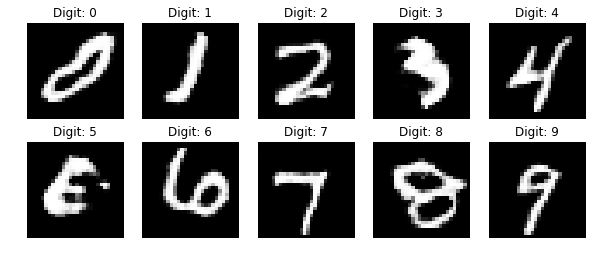

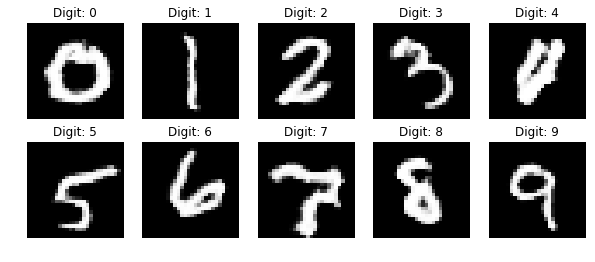

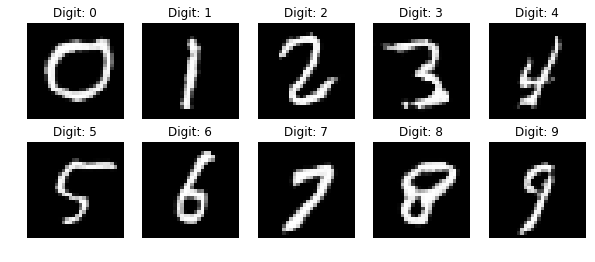

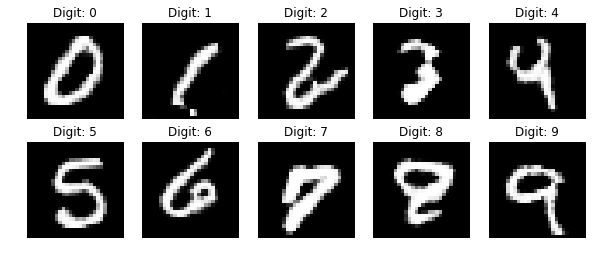

In [9]:
iterations = 12000
batch_size = 32
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

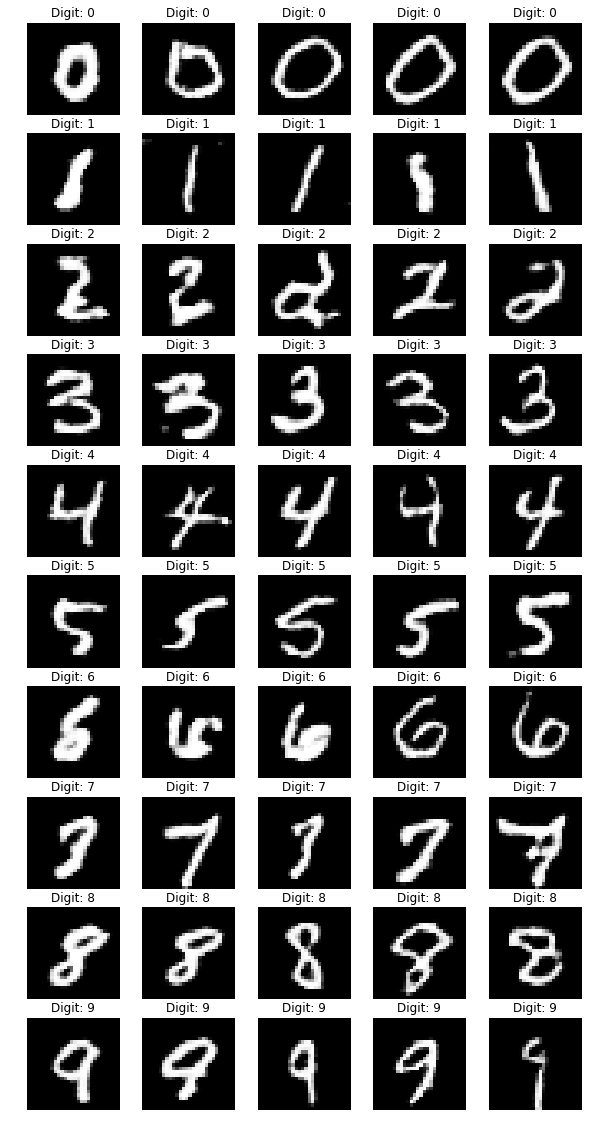

In [10]:
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, 
          (image_grid_rows * image_grid_columns, z_dim))

labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale images to 0-1
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                figsize=(10, 20), sharey=True, sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output image grid
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        axs[i,j].set_title("Digit: %d" % labels_to_generate[cnt]) ## NEW
        cnt += 1

----